In [1]:
# import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
rune_data_filename = 'data/Rune_Data.csv'

rune_dataframe = pd.read_csv(rune_data_filename)
rune_dataframe.head()

,timestamp,Fire_rune,Water_rune,Air_rune,Earth_rune,Mind_rune,Body_rune,Death_rune,Nature_rune,Chaos_rune,Law_rune,Cosmic_rune,Blood_rune,Soul_rune
0,1562371200000,5,5,5,5,4,4,209,204,93,192,115,368,147
1,1562457600000,5,5,5,4,4,4,208,202,93,192,112,376,147
2,1562544000000,5,5,5,5,4,4,208,202,92,190,114,371,147
3,1562630400000,5,5,5,5,4,4,208,203,92,188,112,368,147
4,1562716800000,5,4,5,5,4,4,208,205,92,187,114,368,148


In [3]:
def univariate_data(dataset, history_size):

    
    L = len(dataset)
    for i in range(L - history_size):
        
        train_seq = np.stack(dataset[i:i+history_size] for i in range(L-history_size))
        train_label = np.stack(dataset[i+history_size:i+history_size+1] for i in range(L-history_size))
        
#         train_seq = dataset[i:i+history_size]
#         train_label = dataset[i+history_size:i+history_size+1]
        
        

        
    return train_seq, train_label

In [4]:
uni_data = rune_dataframe['Chaos_rune']
uni_data.index = rune_dataframe['timestamp']

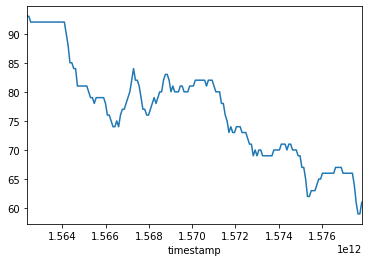

In [5]:
uni_data.plot()

In [6]:
uni_data = uni_data.values
uni_data.shape

(180,)

In [7]:
# normalize data
scaler = MinMaxScaler(feature_range=(-1,1))

uni_data = scaler.fit_transform(uni_data.reshape(-1,1))
uni_data.shape

(180, 1)

In [8]:
uni_data[:11]

array([[1.        ],
       [1.        ],
       [0.94117647],
       [0.94117647],
       [0.94117647],
       [0.94117647],
       [0.94117647],
       [0.94117647],
       [0.94117647],
       [0.94117647],
       [0.94117647]])

In [9]:
history = 10
x_train_uni, y_train_uni = univariate_data(uni_data, history)
y_train_uni = y_train_uni.squeeze(2).squeeze(1)
print(x_train_uni.shape)
print(y_train_uni.shape)

(170, 10, 1)
(170,)


/home/snowballfight/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys
/home/snowballfight/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [10]:
x_train_uni = torch.Tensor(x_train_uni)
y_train_uni = torch.Tensor(y_train_uni)

# create Dataset
dataset = TensorDataset(x_train_uni, y_train_uni)
dataloader = DataLoader(dataset, shuffle=False)


# for num_iter, (seq, label) in enumerate(dataloader):
#     print(num_iter)
#     print(seq.shape)
#     print(label.shape)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class RnnModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super().__init__()
        
        # define some parameters
        self.hidden_dim = hidden_dim

        # define layers
        # RNN layers
        self.lstm = nn.LSTM(input_size, hidden_dim)
        #FC layers
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        x = x.to(device)
        # set initial hidden and cell states
        h0 = torch.zeros(1,1,self.hidden_dim).to(device)
        c0 = torch.zeros(1,1,self.hidden_dim).to(device)
        # forward propagate 
#         print(h0.size())
#         print(c0.size())
#         print(x.size())
#         print(x.view(len(x),1,-1).size())
        out, _ = self.lstm(x.view(len(x),1,-1), (h0, c0))
        
        # decode hidden of last time step
        
        out = self.fc(out.view(len(x), -1))
        
        
        return out[-1]


In [13]:
model = RnnModel(input_size=1, output_size=1, hidden_dim=100)

In [14]:
# hyperparameters
n_epochs = 250
lr = .01

# define loss and optimizer 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
model.to(device)

RnnModel(
  (lstm): LSTM(1, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [16]:
for epoch in range(n_epochs):
    for num_iter, (seq, label) in enumerate(dataloader):
        seq = seq.to(device)
        label = label.to(device)
        seq = seq.reshape(10,1)

        
        
        optimizer.zero_grad()
        
        
        output = model(seq)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

    if epoch%10 == 0:
        print(f'Epoch: {epoch}/{n_epochs}.........')
        print(f'Loss: {loss.item()}')

Epoch: 0/250.........
Loss: 0.007555722258985043
Epoch: 10/250.........
Loss: 0.004926546011120081
Epoch: 20/250.........
Loss: 0.006936505902558565
Epoch: 30/250.........
Loss: 0.002240023808553815
Epoch: 40/250.........
Loss: 1.3310389476828277e-05
Epoch: 50/250.........
Loss: 0.006597284227609634
Epoch: 60/250.........
Loss: 0.001684766262769699
Epoch: 70/250.........
Loss: 0.002468255814164877
Epoch: 80/250.........
Loss: 0.0010204671416431665
Epoch: 90/250.........
Loss: 2.5485682272119448e-05
Epoch: 100/250.........
Loss: 0.0075410050339996815
Epoch: 110/250.........
Loss: 0.01989038847386837
Epoch: 120/250.........
Loss: 0.006206748075783253
Epoch: 130/250.........
Loss: 0.000358465185854584
Epoch: 140/250.........
Loss: 0.0005453895428217947
Epoch: 150/250.........
Loss: 0.0006761127733625472
Epoch: 160/250.........
Loss: 0.006888238713145256
Epoch: 170/250.........
Loss: 0.003325869794934988
Epoch: 180/250.........
Loss: 0.001931651495397091
Epoch: 190/250.........
Loss: 0.001

In [17]:
fut_pred = 10

test_inputs = uni_data[-history:].squeeze(1).tolist()
print(test_inputs)

[-0.5882352941176472, -0.5882352941176472, -0.5882352941176472, -0.5882352941176472, -0.5882352941176472, -0.7058823529411766, -0.8823529411764706, -1.0, -1.0, -0.8823529411764706]


In [18]:
model.eval()

for i in range(history):
    print(len(test_inputs))
    seq = torch.FloatTensor(test_inputs[-history:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())
        
print(test_inputs)        

10
11
12
13
14
15
16
17
18
19
[-0.5882352941176472, -0.5882352941176472, -0.5882352941176472, -0.5882352941176472, -0.5882352941176472, -0.7058823529411766, -0.8823529411764706, -1.0, -1.0, -0.8823529411764706, -0.7196959853172302, -0.5795875787734985, -0.5262758731842041, -0.5454516410827637, -0.574925422668457, -0.5895275473594666, -0.5890487432479858, -0.592475950717926, -0.6085861921310425, -0.631540060043335]


In [19]:
x = np.arange(170,180,1) 

In [20]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[10:]).reshape(-1,1))
print(actual_predictions)

[[63.76516825]
 [66.14701116]
 [67.05331016]
 [66.7273221 ]
 [66.22626781]
 [65.97803169]
 [65.98617136]
 [65.92790884]
 [65.65403473]
 [65.26381898]]


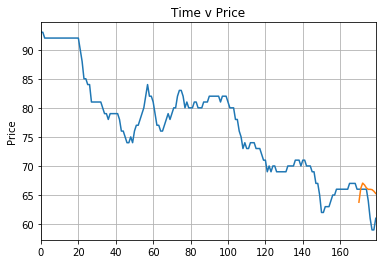

In [21]:
plt.title("Time v Price")
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(scaler.inverse_transform(uni_data))
plt.plot(x, actual_predictions)
plt.show()

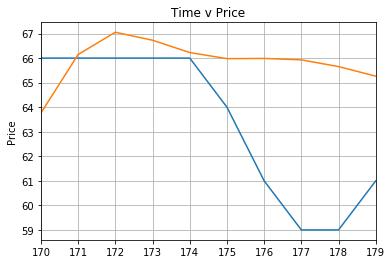

In [22]:
plt.title('Time v Price')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(x,scaler.inverse_transform(uni_data)[-history:])
plt.plot(x,actual_predictions)
plt.show()